https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [1]:
!unzip data2.zip

Archive:  data2.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/eng-fra.txt        
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [2]:
from io import open
import glob
import os
import unicodedata
import string

In [3]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

In [4]:
def find_files(path: str) -> list[str]:
    return glob.glob(path)

In [5]:
def unicode_to_ascii(s: str) -> list[str]:
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [6]:
def read_lines(filename: str) -> list[str]:
    with open(filename, encoding = 'utf-8') as some_file:
        return[unicode_to_ascii(line.strip()) for line in some_file]

In [7]:
category_lines = {}
all_categories = []

for fname in find_files('data/names/*.txt'):
    cat = os.path.splitext(os.path.basename(fname))[0]
    all_categories.append(cat)
    lines = read_lines(fname)
    category_lines[cat] = lines

n_categories = len(all_categories)

if (n_categories == 0):
    raise RuntimeError('Data not found')

print(f'# categories: {n_categories} {all_categories}')
print(unicode_to_ascii("O'Néàl"))

# categories: 18 ['Irish', 'Dutch', 'Vietnamese', 'Korean', 'Czech', 'German', 'Polish', 'Japanese', 'Scottish', 'Chinese', 'French', 'Italian', 'Arabic', 'Greek', 'Spanish', 'Russian', 'English', 'Portuguese']
O'Neal


In [8]:
import torch
import torch.nn as nn

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.flatten = nn.Flatten()
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, category: torch.Tensor, input_: torch.Tensor, hidden: torch.Tensor):
        input_combined = torch.cat((category, input_, hidden), 1)
        #input_combined = self.flatten(input_combined)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


In [10]:
import random

def random_choice(l: list):
    return l[random.randint(0,len(l)-1)]

def random_training_pair():
    cat_ = random_choice(all_categories)
    line = random_choice(category_lines[cat_])
    return cat_, line

In [11]:
def category_tensor(category: str):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

In [12]:
def input_tensor(line: str):
    tensor = torch.zeros(len(line), 1, n_letters)

    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1

    return tensor

In [13]:
def target_tensor(line: str):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [14]:
def random_training_example():
    _cat, _line = random_training_pair()
    cat_tensor = category_tensor(_cat)
    input_line_tensor = input_tensor(_line)
    target_line_tensor = target_tensor(_line)

    return cat_tensor, input_line_tensor, target_line_tensor

In [15]:
cat_temp,input_temp, output_temp = random_training_example()
print(cat_temp.shape)
print(input_temp.shape)
print(output_temp.shape)

torch.Size([1, 18])
torch.Size([7, 1, 59])
torch.Size([7])


In [16]:
print(output_temp)

tensor([14,  8, 11,  4,  0, 13, 58])


In [30]:


def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.init_hidden().to('cuda')
    rnn.zero_grad()

    loss = torch.Tensor([0]).to('cuda')
    for i in range(input_line_tensor.size(0)):

        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -lr)

    return output, loss.item()/int(input_line_tensor.size(0))

In [31]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [32]:
n_iters = 100000
print_every = 1000
plot_every = 500
all_losses = []
total_loss = 0
criterion = nn.NLLLoss()
lr = 3e-4
rnn = RNN(n_letters, 128, n_letters).to('cuda')

start = time.time()

for iter in range(1, n_iters + 1):
    cat_tensor, in_tensor, tar_tensor = random_training_example()
    output, loss = train(cat_tensor.to('cuda'), in_tensor.to('cuda'), tar_tensor.to('cuda'))
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 6s (1000 1%) 3.8775
0m 11s (2000 2%) 2.7982
0m 17s (3000 3%) 3.7893
0m 22s (4000 4%) 3.3884
0m 28s (5000 5%) 3.5511
0m 33s (6000 6%) 3.0402
0m 39s (7000 7%) 3.6488
0m 44s (8000 8%) 3.0991
0m 50s (9000 9%) 3.0355
0m 55s (10000 10%) 2.7439
1m 0s (11000 11%) 3.1781
1m 6s (12000 12%) 2.9726
1m 12s (13000 13%) 2.6083
1m 17s (14000 14%) 3.2895
1m 22s (15000 15%) 2.2413
1m 28s (16000 16%) 3.1726
1m 33s (17000 17%) 2.6859
1m 39s (18000 18%) 2.8301
1m 44s (19000 19%) 2.5875
1m 50s (20000 20%) 2.0607
1m 55s (21000 21%) 2.1514
2m 1s (22000 22%) 2.6433
2m 6s (23000 23%) 2.5532
2m 13s (24000 24%) 3.2694
2m 18s (25000 25%) 3.5863
2m 23s (26000 26%) 2.8102
2m 29s (27000 27%) 3.0266
2m 34s (28000 28%) 2.2171
2m 40s (29000 28%) 3.4831
2m 45s (30000 30%) 3.0220
2m 50s (31000 31%) 2.6699
2m 56s (32000 32%) 2.7794
3m 1s (33000 33%) 2.6660
3m 7s (34000 34%) 2.3064
3m 12s (35000 35%) 3.0500
3m 18s (36000 36%) 2.1584
3m 23s (37000 37%) 2.9253
3m 28s (38000 38%) 2.9519
3m 34s (39000 39%) 2.8708
3m 39s (400

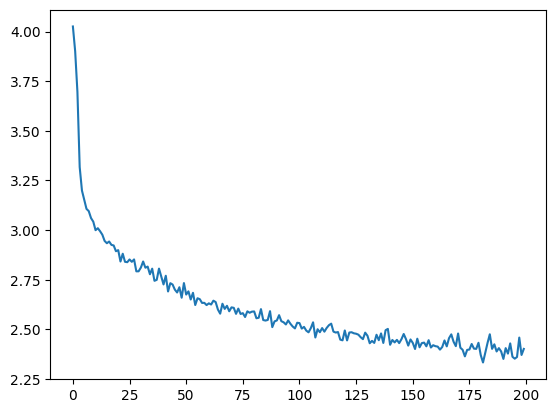

In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [40]:
max_length = 100

# sample from a category and starting letter
def sample(category, start_letter = 'A'):
    with torch.no_grad():
        cat_tensor = category_tensor(category).to('cuda')
        in_tensor = input_tensor(start_letter).to('cuda')
        hidden = rnn.init_hidden().to('cuda')

        out_name = start_letter

        for i in range(max_length):
            out, hidden = rnn(cat_tensor, in_tensor[0], hidden)
            topv, topi = out.topk(1)
            topi = topi[0][0]
            if (topi == (n_letters - 1)):
                break

            else:
                letter = all_letters[topi]
                out_name += letter
            in_tensor = input_tensor(letter).to('cuda')
    return out_name

In [41]:
sample('Irish','A')

'Alanan'

In [42]:
sample('Irish','A')

'Alana'

In [43]:
sample('Irish','A')

'Alana'

In [44]:
sample('Irish','A')

'Alanan'

In [45]:
sample('Irish','A')

'Allin'

In [46]:
sample('Irish','A')

'Arana'

In [47]:
sample('Irish','A')

'Allallan'

In [48]:
sample('English','A')

'Allen'

In [49]:
sample('Irish','A')

'Alana'

In [50]:
sample('English','A')

'Alan'

In [51]:
sample('English','A')

'Allen'